## Note

This analysis is heavily inspired by the interactive book ['Bayesian Methods for Hackers - Probabilistic Programming and Bayesian Inference'](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) by [Cam Davidson-Pilon](https://twitter.com/Cmrn_DP).
The books comes as a series of Jupyter notebooks which means that the reader can easily change parameters of
the Bayesian analyses and see how they affect the result. I highly recommend this is book which is
freely available on [GitHub](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)
and on [Amazon](http://www.amazon.com/Bayesian-Methods-Hackers-Probabilistic-Addison-Wesley/dp/0133902838).

In [10]:
import dateutil.parser
import fitbit
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import numpy as np
import pandas
import pymc as pm
import seaborn
from bin.parse_credentials import parse_client_credentials, parse_tokens
%matplotlib inline

In [3]:
# prepare data download using FitBit API
client_id, client_secret = parse_client_credentials('client_id_secret.txt')
!./gather_keys_oauth2.py $client_id $client_secret >access_refresh_tokens.txt 2>/dev/null
access_token, refresh_token = parse_tokens('access_refresh_tokens.txt')
authd_client = fitbit.Fitbit(client_id, client_secret, oauth2=True,
                             access_token=access_token,
                             refresh_token=refresh_token)

# download step data of last three months
steps_ts = authd_client.time_series('activities/steps', period='3m')

# convert to datetime objects
date_steps = [(dateutil.parser.parse(date_steps_dict['dateTime']), int(date_steps_dict['value']))
              for date_steps_dict in steps_ts['activities-steps']]

# store as pandas data frame and print most recent daily step counts
date_steps_df = pandas.DataFrame(date_steps, columns=('Date', 'Steps'))
date_steps_df.tail()

,Date,Steps
88,2016-05-25,18617
89,2016-05-26,12609
90,2016-05-27,19371
91,2016-05-28,18048
92,2016-05-29,9851


We also import the [seaborn](https://stanford.edu/~mwaskom/software/seaborn/) library to create
a nice looking plot of the daily step counts.

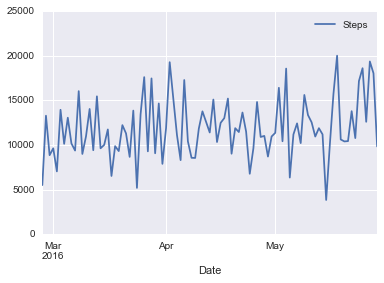

In [4]:
date_steps_df.plot(x='Date')

In [9]:
step_data = date_steps_df['Steps']
n_step_data = len(step_data)

alpha = 1.0 / step_data.mean() 
                               
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_step_data)

@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_step_data)
    out[:tau] = lambda_1  # lambda before tau is lambda1
    out[tau:] = lambda_2  # lambda after (and including) tau is lambda2
    return out

observation = pm.Poisson("obs", lambda_, value=step_data, observed=True)

model = pm.Model([observation, lambda_1, lambda_2, tau])

mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

 [-----------------100%-----------------] 40000 of 40000 complete in 9.2 sec

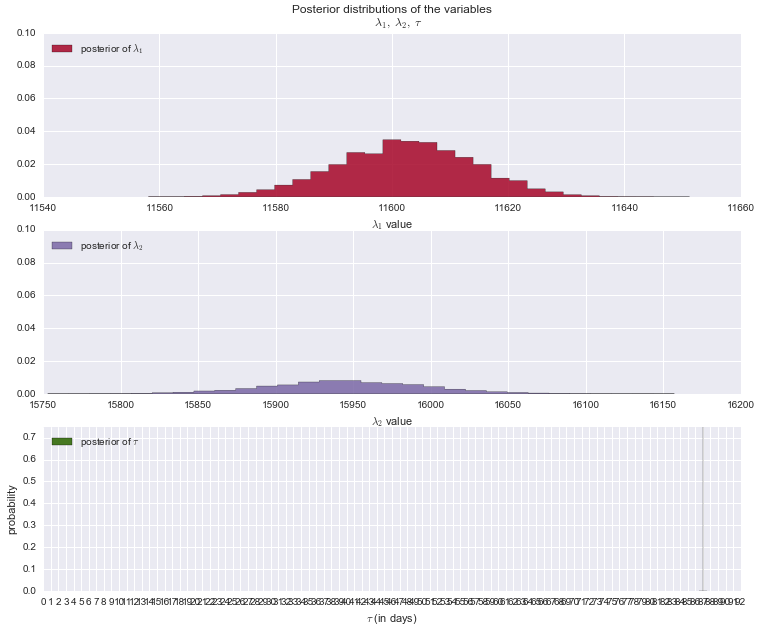

In [14]:
figsize(12.5, 10)
# histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
#plt.xlim([15, 30])
plt.ylim([0, .1])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
#plt.xlim([15, 30])
plt.ylim([0, .1])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_step_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_step_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
#plt.xlim([35, len(count_data) - 20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");